In [1]:
import sys
sys.path.append("../python")

from importlib import reload
import h5py
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.patches as pt
import utility_functions
import meshio
import evaluations
import json
import math

from matplotlib.colors import ListedColormap
cmap_blue = ListedColormap(["white", "lightsteelblue", "cornflowerblue", "royalblue", "blue", "navy"])
cmap = ListedColormap(["white", "darkorange", "gold", "navy", "steelblue", "yellowgreen"])
cmap_light = ListedColormap(["white", "bisque", "gold", "lavender", "aliceblue", "honeydew"])
cmap_gray = ListedColormap(["lightgray"])
#cmap = ListedColormap(["white", "cornflowerblue", "blue", "royalblue", "navy", "lightsteelblue"])


In [2]:
parameters_path = "../configs/test_mh/mh_test_3_64_pi_18.json"
    
file = open(parameters_path)
config = json.load(file)
file.close()

In [3]:
chain = 0

# Set center
center = (config["Geometry"]["Center"]["x"], config["Geometry"]["Center"]["y"])

# Set dipole
position = (config["ModelConfig"]["Dipoles"][chain][0],config["ModelConfig"]["Dipoles"][chain][1])
rho = config["ModelConfig"]["Dipoles"][chain][2]

sample_path = config["Setup"]["OutputPath"] + config["Sampling"]["ResultFile"] + "_"+ str(chain) +".h5"
#sample_path = "/home/anne/Masterarbeit/masterarbeit/2d/results/test_mh/mh_0.h5"
fin = h5py.File(sample_path)
samples = np.array( fin['/samples'] )
fin.close()

s_ref = utility_functions.get_dipole(position,center,rho)
sample_dict = {
    "x": samples[0],
    "y": samples[1],
    "rho": samples[2]
}

sample_dataset = az.dict_to_dataset(sample_dict)

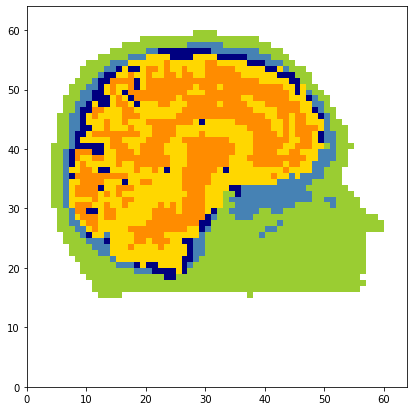

In [4]:
fig, axis = plt.subplots(figsize=(7,7))

mesh = np.load(config[config["Sampling"]["Levels"][-1]]["Mesh"])
#electrodes = np.array(np.load(config["GeneralLevelConfig"]["Electrodes"])["arr_0"])
#print(len(electrodes))

elements = mesh['elements']
nodes = mesh['nodes']
labels = mesh['labels']
gray_probs = mesh['gray_probs']

n = int(math.sqrt(len(elements)))

z = np.ndarray((n,n),float)

for k in range(n):
    for j in range(n):
        z[j,k] = labels[k+n*j]

axis.pcolormesh(z,cmap=cmap)
#axis.scatter(electrodes[:,0],electrodes[:,1],c="red")
axis.set_aspect(1)



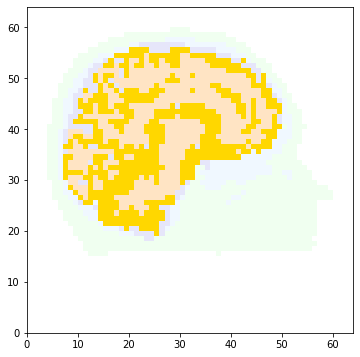

In [5]:
fig, axis = plt.subplots(figsize=(6,6))

point = (config["ModelConfig"]["Dipoles"][chain][0],config["ModelConfig"]["Dipoles"][chain][1],config["ModelConfig"]["Dipoles"][chain][2])
start = [127,127]

axis.pcolormesh(z,cmap=cmap_light)
axis.set_aspect(1)


evaluations.draw_dipole(axis, [start[0],start[1],0], "green", 20)
evaluations.draw_dipole(axis, point, "red",20)

plt.show()

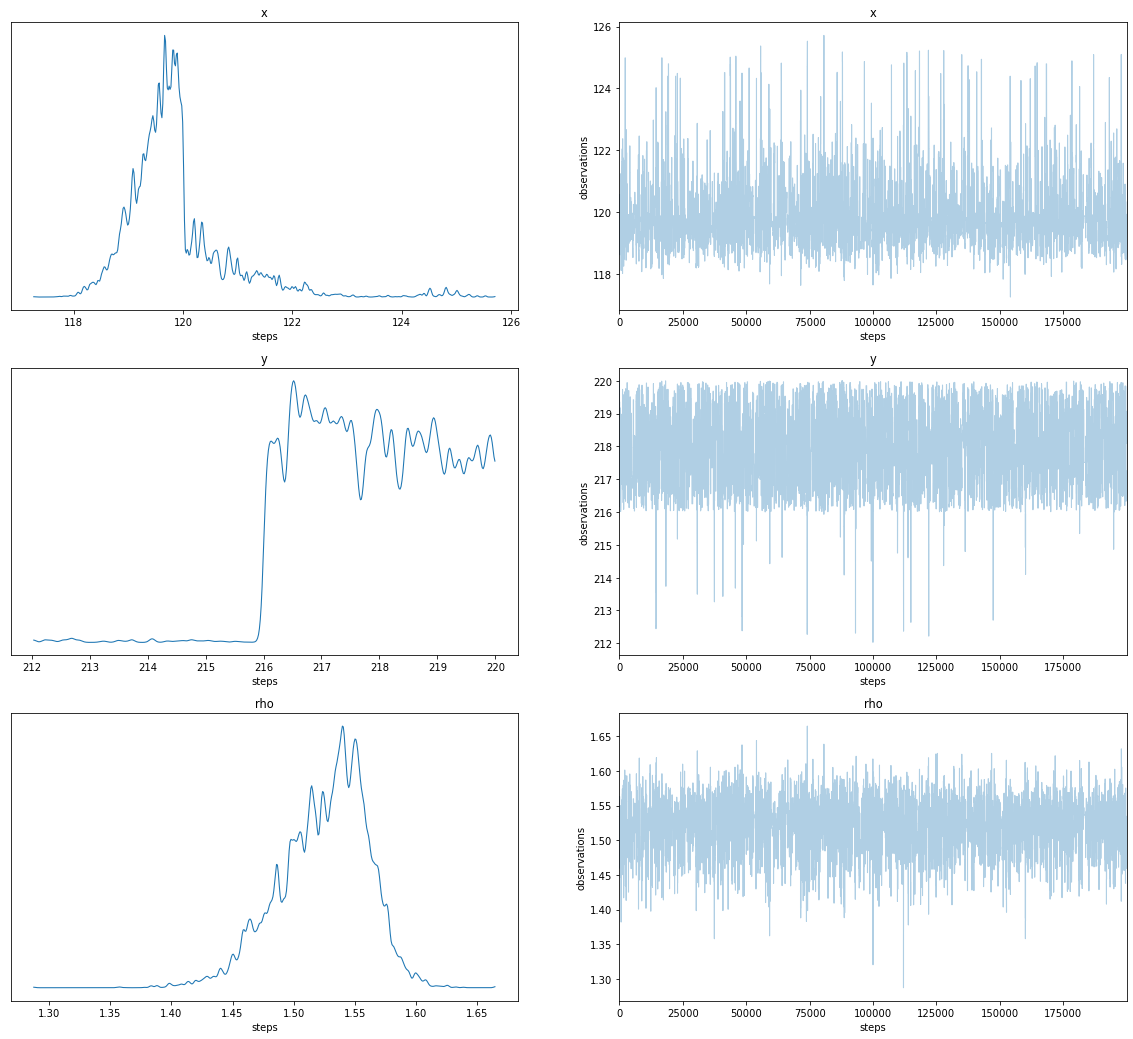

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(20,18))

for ax in axes.flatten():
    ax.set_xlabel('steps')

axes[0,1].set_ylabel('observations')
axes[1,1].set_ylabel('observations')
axes[2,1].set_ylabel('observations')
#axes[0,1].set_ylim(60,130)

p = az.plot_trace(sample_dataset, axes=axes)

(-0.25, 1.0)

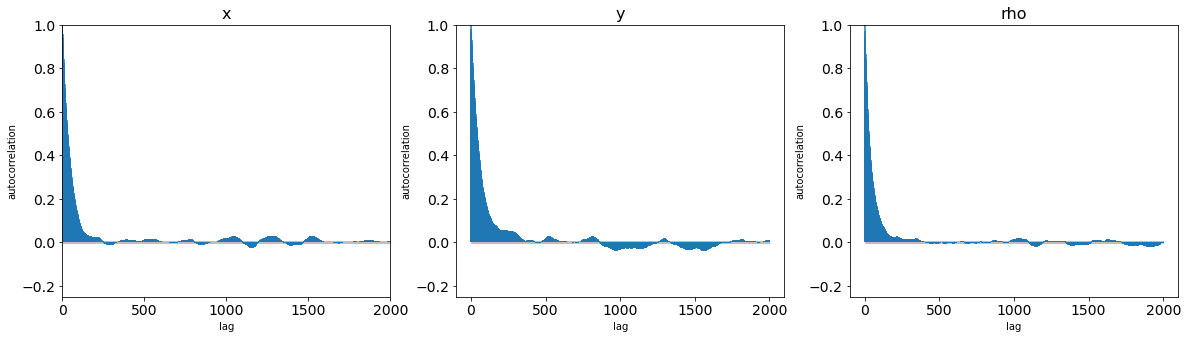

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

p = az.plot_autocorr(sample_dataset, ax = axes, max_lag=2000, combined=True, figsize=(20,4))

axes[0].set_ylabel('autocorrelation')
axes[0].set_xlabel('lag')
axes[1].set_ylabel('autocorrelation')
axes[1].set_xlabel('lag')
axes[2].set_ylabel('autocorrelation')
axes[2].set_xlabel('lag')

axes[0].set_ylim(-0.25,1)
axes[1].set_ylim(-0.25,1)
axes[2].set_ylim(-0.25,1)



In [8]:
bins = np.zeros((n,n))
angles = np.zeros((n,n))
samples_t = np.transpose(samples)
for s in samples_t:
        c = utility_functions.find_next_center(mesh, "hex", s)
        bins[int(c[1]),int(c[0])] += 1
        angles[int(c[1]),int(c[0])] += s[2]

angles = angles/bins
bins = bins/len(samples[0])


/tmp/ipykernel_19232/2913566367.py:9: RuntimeWarning: invalid value encountered in true_divide
  angles = angles/bins


In [9]:
'''sample_path_2 = "/home/anne/Masterarbeit/masterarbeit/2d/results/test_01/mh_2_" + str(chain) +".h5"
fin = h5py.File(sample_path_2)
samples_2 = np.array( fin['/samples'] )
fin.close()

sample_dict_2 = {
    "x": samples_2[0],
    "y": samples_2[1],
    "rho": samples_2[2]
}

sample_dataset_2 = az.dict_to_dataset(sample_dict_2)

bins_2 = np.zeros((n,n))
samples_t_2 = np.transpose(samples_2)
for s in samples_t_2:
        c = utility_functions.find_next_center(mesh, "hex", s)
        bins_2[int(c[1]),int(c[0])] += 1

bins_2 = bins_2/len(samples_2[0])'''

'sample_path_2 = "/home/anne/Masterarbeit/masterarbeit/2d/results/test_01/mh_2_" + str(chain) +".h5"\nfin = h5py.File(sample_path_2)\nsamples_2 = np.array( fin[\'/samples\'] )\nfin.close()\n\nsample_dict_2 = {\n    "x": samples_2[0],\n    "y": samples_2[1],\n    "rho": samples_2[2]\n}\n\nsample_dataset_2 = az.dict_to_dataset(sample_dict_2)\n\nbins_2 = np.zeros((n,n))\nsamples_t_2 = np.transpose(samples_2)\nfor s in samples_t_2:\n        c = utility_functions.find_next_center(mesh, "hex", s)\n        bins_2[int(c[1]),int(c[0])] += 1\n\nbins_2 = bins_2/len(samples_2[0])'

TypeError: Dimensions of C (0, 0) are incompatible with X (20) and/or Y (20); see help(pcolormesh)

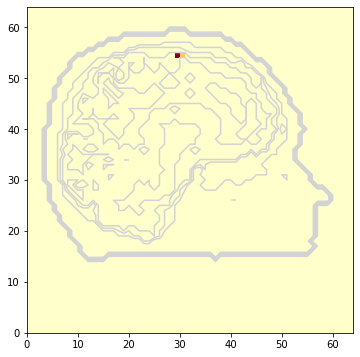

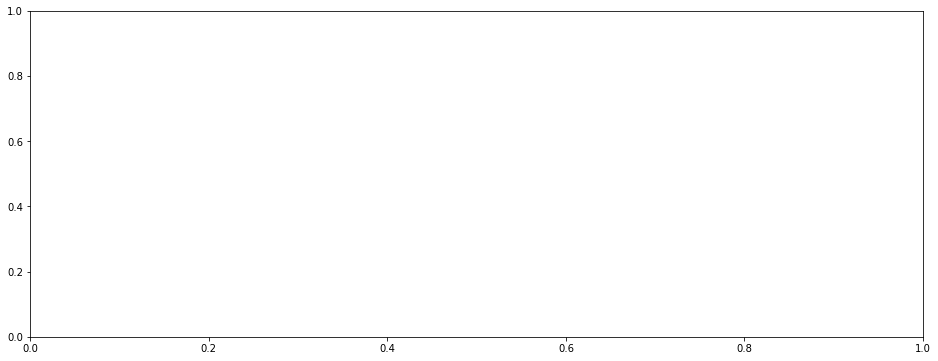

In [10]:
fig, axis = plt.subplots(figsize=(16,6))
fig.subplots_adjust(wspace=.5)

axis.pcolormesh(bins, cmap="YlOrRd")
axis.contour(z, cmap=cmap_gray, levels = [0,1,2,3,4,5])
axis.set_aspect(1)


xmin = int(point[0] - 10)
xmax = int(point[0] + 10)
ymin = int(point[1] - 10)
ymax = int(point[1] + 10)
x = nodes[xmin:xmax,0]
y = nodes[ymin:ymax,0]

fig, axis = plt.subplots(figsize=(16,6))
fig.subplots_adjust(wspace=.5)

im = axis.pcolormesh(x,y,bins[ymin:ymax,xmin:xmax], cmap="YlOrRd")
plt.colorbar(im)
axis.contour(x,y,z[ymin:ymax,xmin:xmax], cmap=cmap_gray, levels = [0,1,2,3,4,5])
axis.set_aspect(1)
evaluations.draw_dipole(axis, point, "green",2, 0.4)

'''im = axis[1].pcolormesh(x,y,bins_2[ymin:ymax,xmin:xmax], cmap="YlOrRd")
axis[1].contour(x,y,z[ymin:ymax,xmin:xmax], cmap=cmap_gray, levels = [0,1,2,3,4,5])
axis[1].set_aspect(1)
evaluations.draw_dipole(axis[1], point, "green",2, 0.4)'''

fig, axis = plt.subplots(figsize=(16,6))
fig.subplots_adjust(wspace=.5)

im = axis.pcolormesh(x,y,bins[ymin:ymax,xmin:xmax], cmap="YlOrRd")
plt.colorbar(im)
axis.contour(x,y,z[ymin:ymax,xmin:xmax], cmap=cmap_gray, levels = [0,1,2,3,4,5])
axis.set_aspect(1)

evaluations.draw_dipole(axis, point, "green",2, 0.4)

for i in range(n):
    for j in range(n):
        if bins[i,j] > 0.01:
            p = np.array([j,i,angles[i,j]])
            evaluations.draw_dipole(axis, p, "red", 1, 0.1)




